<a href="https://colab.research.google.com/github/1s5ac/STA365_HW/blob/main/STA365%E2%80%94A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

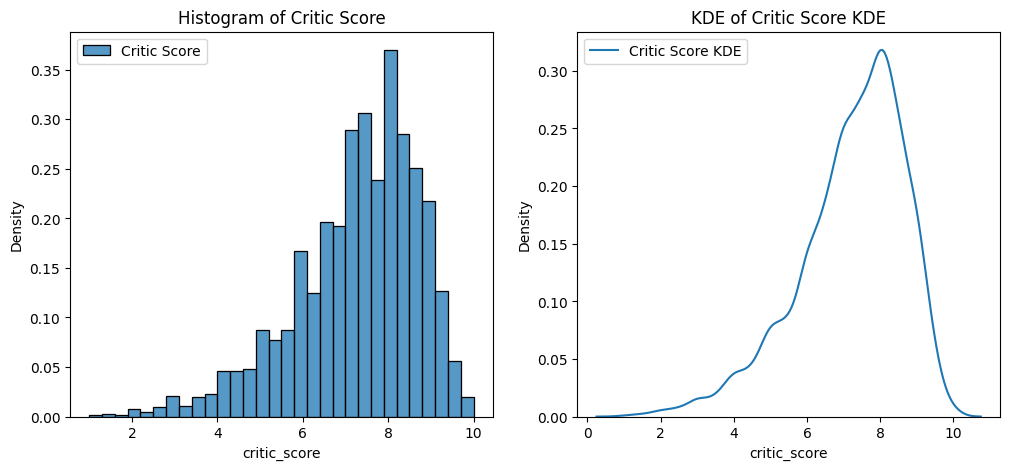

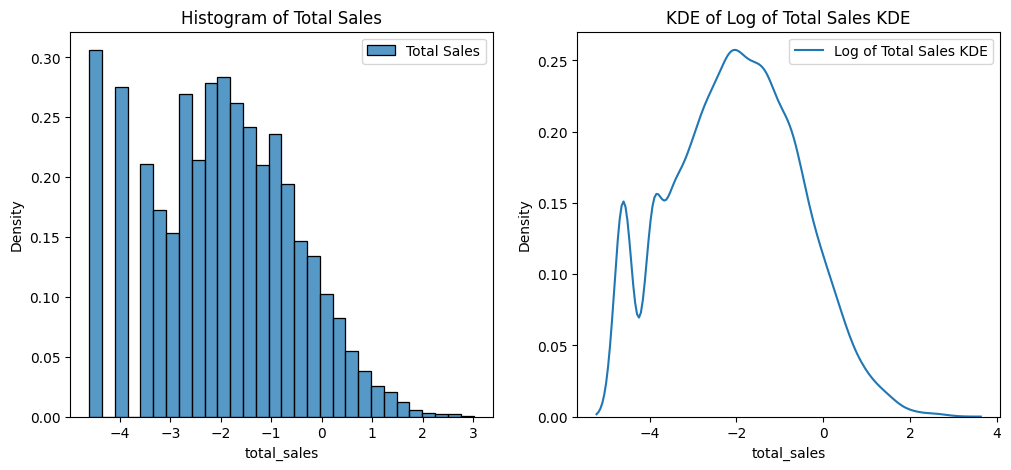

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     7.22  0.02    7.19     7.26       0.00     0.00   4645.60   3688.54   
alpha  1.68  1.17    0.06     3.78       0.02     0.02   2729.07   3171.49   
beta   2.84  2.10    0.02     6.53       0.03     0.03   3365.03   2580.39   
tau    0.47  0.01    0.46     0.49       0.00     0.00   4461.46   3845.55   

       r_hat  
mu       1.0  
alpha    1.0  
beta     1.0  
tau      1.0  


     mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  -2.01  0.01   -2.04    -1.99        0.0      0.0   2035.94   1461.38   
tau  0.47  0.01    0.46     0.48        0.0      0.0   2043.39   1716.10   

     r_hat  
mu     1.0  
tau    1.0  


An error occurred while performing PPC: different number of dimensions on data and dims: 3 vs 2


An error occurred while performing PPC: different number of dimensions on data and dims: 3 vs 2


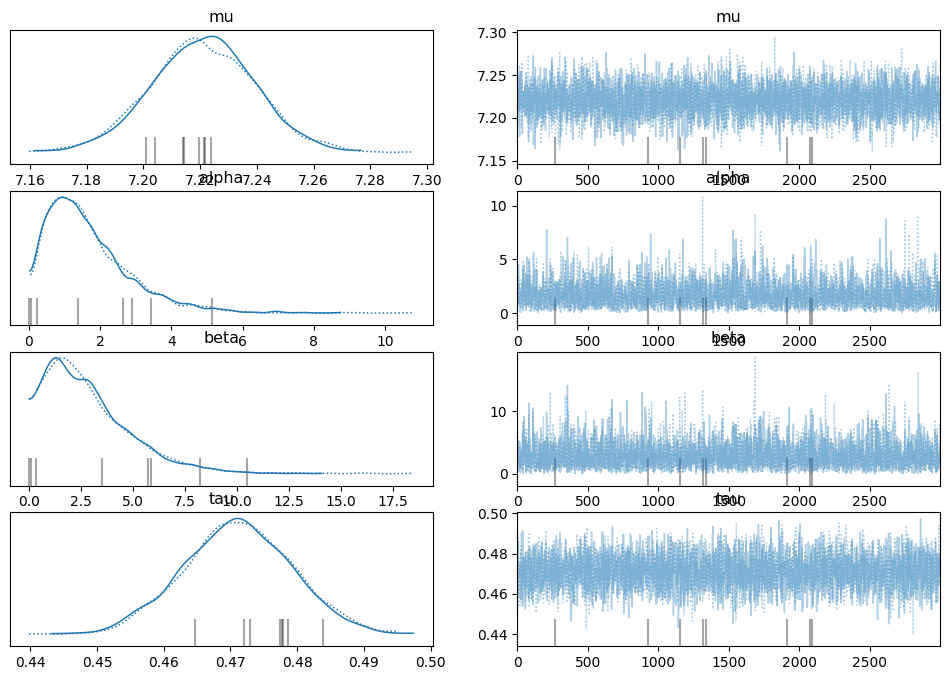

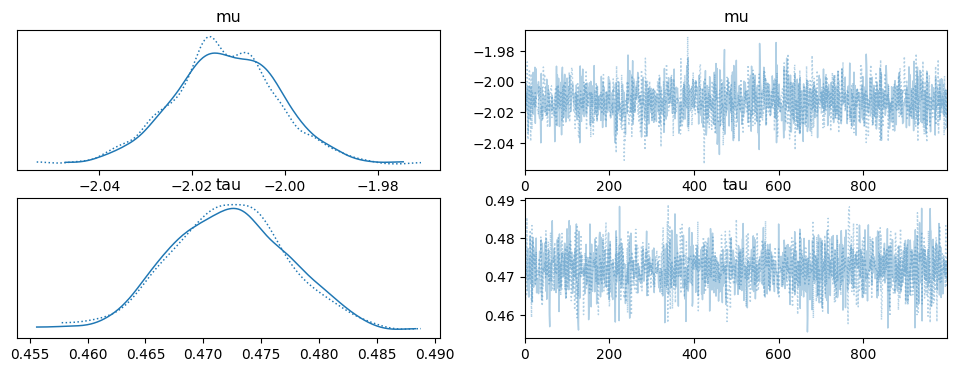

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# Function for plotting histograms and KDEs
def plot_hist_kde(data, column, log_transform=False, bins=30, label='', kde_label=''):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    if log_transform:
        data_to_plot = np.log(data[column][data[column] > 0]).replace([np.inf, -np.inf], np.nan).dropna()
    else:
        data_to_plot = data[column].dropna()
    sns.histplot(data_to_plot, bins=bins, label=label, kde=False, stat='density')
    plt.title(f'Histogram of {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.kdeplot(data_to_plot, label=kde_label)
    plt.title(f'KDE of {kde_label}')
    plt.legend()
    plt.show()

# Function for performing posterior predictive checks
def perform_ppc(model, trace, data, observed_name, bins=30):
    with model:
        try:
            ppc = pm.sample_posterior_predictive(trace, var_names=[observed_name])
            ppc_data = ppc[observed_name].flatten()
            _, ax = plt.subplots()
            sns.histplot(data, bins=bins, kde=False, label='Observed Data', color='blue', stat='density')
            sns.kdeplot(ppc_data, label='Posterior Predictive', color='orange', ax=ax)
            ax.legend()
            plt.show()
        except Exception as e:
            print(f"An error occurred while performing PPC: {e}")


# Load the dataset
url = 'https://raw.githubusercontent.com/1s5ac/STA365_HW/main/vgchartz-2024.csv'
data = pd.read_csv(url)


# Perform exploratory data analysis
plot_hist_kde(data, 'critic_score', label='Critic Score', kde_label='Critic Score KDE')
plot_hist_kde(data, 'total_sales', log_transform=True, label='Total Sales', kde_label='Log of Total Sales KDE')

# Normal-Gamma model for critic scores
with pm.Model() as normal_gamma_model:
    # Prior distributions
    alpha = pm.Exponential('alpha', 1/np.var(data['critic_score'].dropna()))
    beta = pm.Exponential('beta', 1/np.var(data['critic_score'].dropna()))
    tau = pm.Gamma('tau', alpha=alpha, beta=beta)
    mu = pm.Normal('mu', mu=data['critic_score'].dropna().mean(), sigma=np.sqrt(1/tau))

    # Likelihood of observed data
    observation = pm.Normal('observation', mu=mu, sigma=np.sqrt(1/tau), observed=data['critic_score'].dropna())

    # Posterior sampling
    normal_gamma_trace = pm.sample(3000)

# Analyze the MCMC chains for the normal-gamma model
az.plot_trace(normal_gamma_trace)
normal_gamma_summary = az.summary(normal_gamma_trace, round_to=2)
print(normal_gamma_summary)

# Normal model for log-transformed total sales
with pm.Model() as non_normal_model:
    # Calculated standard deviation and precision
    positive_sales = data['total_sales'][data['total_sales'] > 0]
    logged_positive_sales = np.log(positive_sales)
    sigma_prior = logged_positive_sales.std()
    tau_prior = 1 / sigma_prior**2

    # Priors using tau instead of sd
    mu = pm.Normal('mu', mu=logged_positive_sales.mean(), tau=tau_prior)
    tau = pm.Gamma('tau', alpha=1, beta=1/tau_prior)

    # Likelihood using tau
    sales_obs = pm.Normal('sales_obs', mu=mu, tau=tau, observed=logged_positive_sales)

    # Inference
    non_normal_trace = pm.sample(1000, tune=500)

# Analyze the MCMC chains for the non-normal model
az.plot_trace(non_normal_trace)
non_normal_summary = az.summary(non_normal_trace, round_to=2)
print(non_normal_summary)

# Perform posterior predictive checks
perform_ppc(normal_gamma_model, normal_gamma_trace, data['critic_score'].dropna(), 'observation')
perform_ppc(non_normal_model, non_normal_trace, logged_positive_sales, 'sales_obs')

plt.show()

I used chatgpt in this assignment to help me debug and point out what code I could integrate and optimize to be more concise.